# ARIMA 

In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [10, 7.5]

## S&P500 Data 

In [3]:
data = pd.read_csv('data\spy_data.csv')
data.head()

,Date,Close
0,2012-01-03,127.500000
1,2012-01-04,127.699997
2,2012-01-05,128.039993
3,2012-01-06,127.709999
4,2012-01-09,128.020004


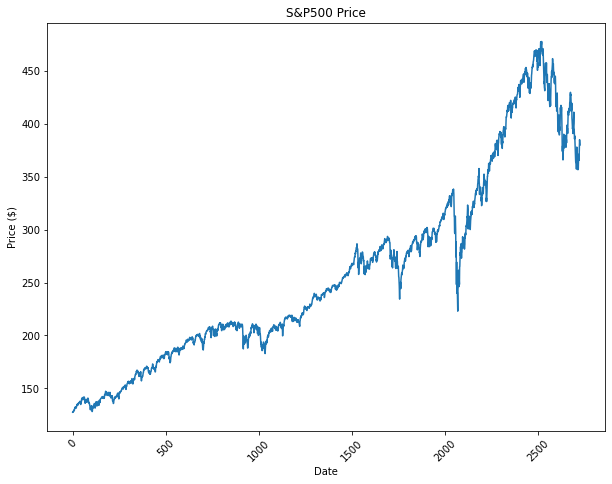

In [4]:
plt.plot(data['Close'])
plt.title('S&P500 Price')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

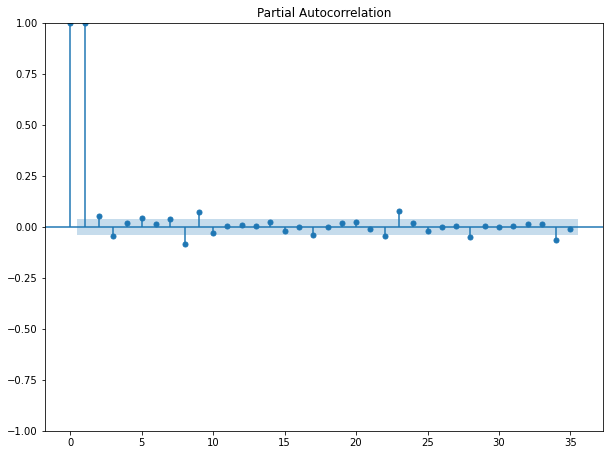

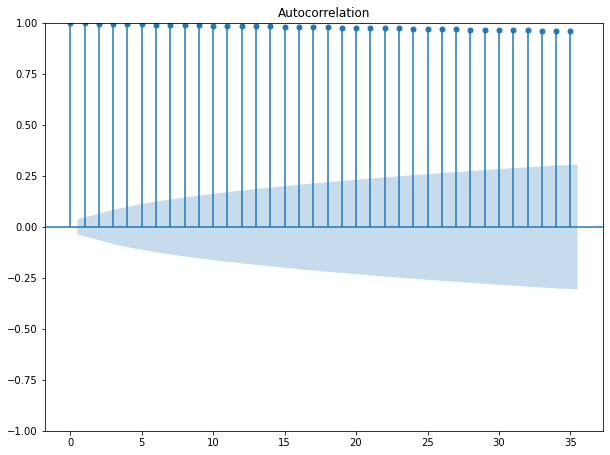

In [5]:
plot_pacf(data['Close']);
plot_acf(data['Close']);

#ACF and PACF data shows that it is not stationary and ADF test confirms that as well as P-value is not less that .05

In [6]:
ad_fuller_result = adfuller(data['Close'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.8058198941412471
p-value: 0.8174065370809298


#As the data is not stationary, take difference

In [7]:
data['data_tr_1'] = np.log(data['Close'])
data['data_tr_1'] = data['data_tr_1'].diff()

data.head(10)

,Date,Close,data_tr_1
0,2012-01-03,127.500000,NaN
1,2012-01-04,127.699997,0.001567
2,2012-01-05,128.039993,0.002659
3,2012-01-06,127.709999,-0.002581
4,2012-01-09,128.020004,0.002424
5,2012-01-10,129.130005,0.008633
6,2012-01-11,129.199997,0.000542
7,2012-01-12,129.509995,0.002396
8,2012-01-13,128.839996,-0.005187
9,2012-01-17,129.339996,0.003873


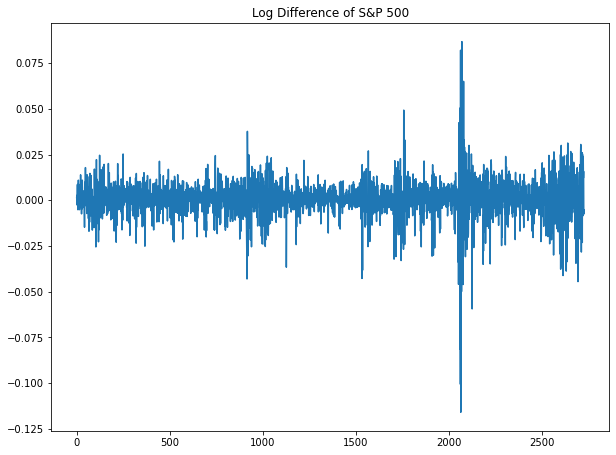

In [8]:
plt.plot(data['data_tr_1'])
plt.title("Log Difference of S&P 500")
plt.show()

In [9]:
ad_fuller_result = adfuller(data['data_tr_1'][1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -10.977977252136343
p-value: 7.584297993386063e-20


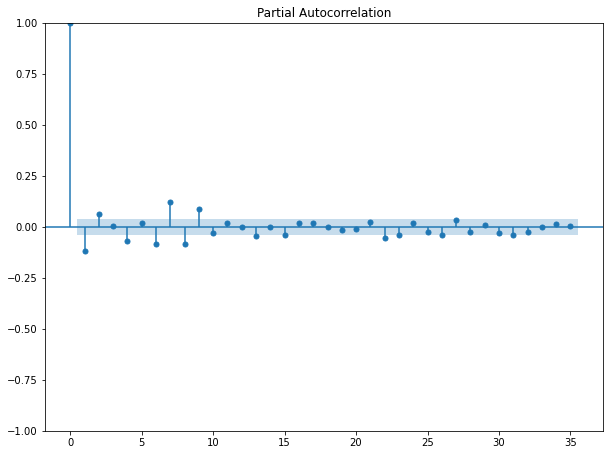

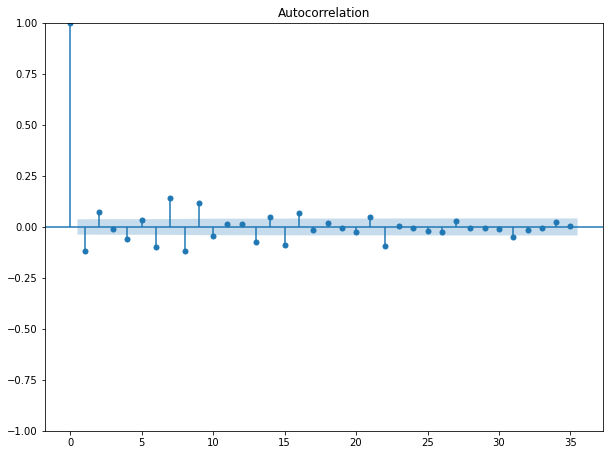

In [10]:
plot_pacf(data['data_tr_1'][1:]);
plot_acf(data['data_tr_1'][1:]);

In [11]:
def optimize_ARIMA(endog, order_list):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        endog - the observed variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=order, simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [12]:
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
order_list[:10]

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

In [13]:
result_df = optimize_ARIMA(data['Close'], order_list)
result_df

,"(p, d, q)",AIC
0,"(6, 1, 7)",13795.355968
1,"(7, 1, 7)",13797.044899
2,"(7, 1, 6)",13798.613964
3,"(6, 1, 6)",13798.756352
4,"(5, 1, 7)",13804.109154
...,...,...
59,"(3, 1, 1)",13915.326817
60,"(1, 1, 0)",13917.757475
61,"(0, 1, 1)",13920.026352
62,"(7, 1, 4)",13927.143418


In [14]:
best_model = SARIMAX(data['Close'], order=(6,1,7), simple_differencing=False)
res = best_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2724
Model:               SARIMAX(6, 1, 7)   Log Likelihood               -6883.678
Date:                Wed, 09 Nov 2022   AIC                          13795.356
Time:                        15:51:45   BIC                          13878.089
Sample:                             0   HQIC                         13825.262
                               - 2724                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2435      0.161     -7.714      0.000      -1.559      -0.928
ar.L2          0.0293      0.152      0.192      0.848      -0.269       0.328
ar.L3          0.3275      0.087      3.751      0.0

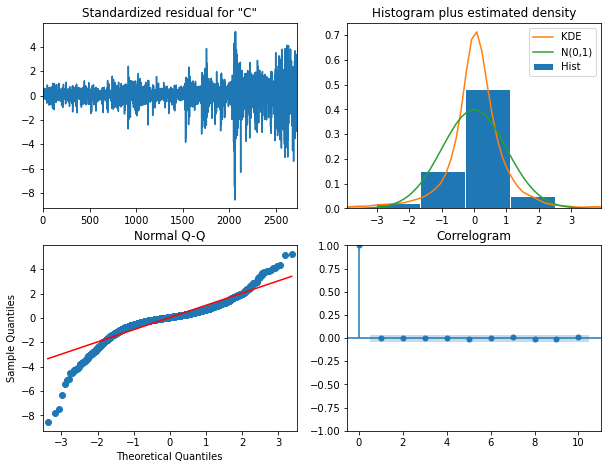

In [15]:
res.plot_diagnostics();

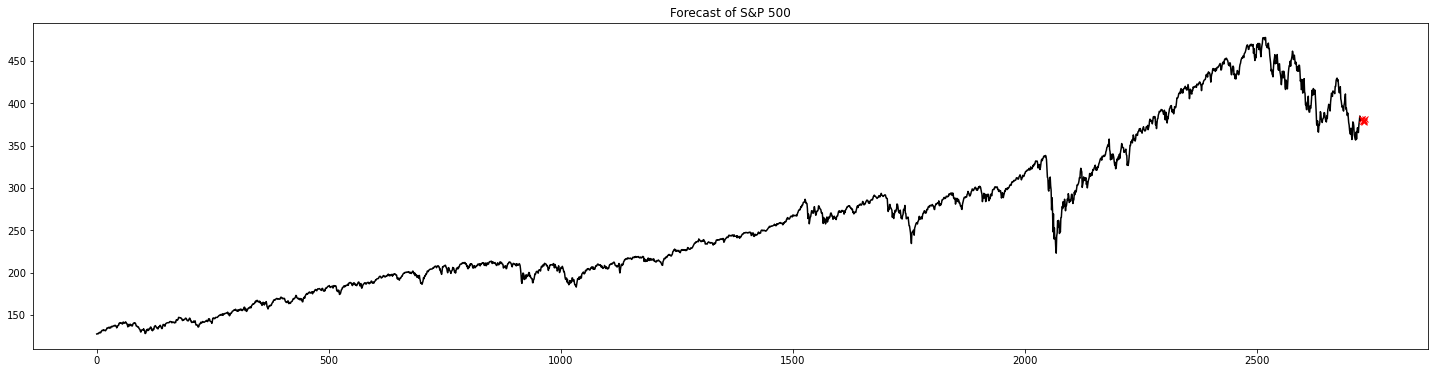

In [16]:
n_forecast = 8
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots(figsize=(25,6))
ax.plot(data['Close'], 'black')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--', marker="x", color='red')
ax.set(title='Forecast of S&P 500')
plt.show()

In [17]:
data['model'] = predict.predicted_mean
data.tail(10)

,Date,Close,data_tr_1,model
2714,2022-10-14,357.630005,-0.023052,366.663408
2715,2022-10-17,366.820007,0.025372,359.514894
2716,2022-10-18,371.130005,0.011681,366.012087
2717,2022-10-19,368.500000,-0.007112,370.479849
2718,2022-10-20,365.410004,-0.008421,367.232828
2719,2022-10-21,374.290009,0.024011,364.070020
2720,2022-10-24,378.869995,0.012162,373.762124
2721,2022-10-25,384.920013,0.015842,377.645513
2722,2022-10-26,382.019989,-0.007563,387.935820
2723,2022-10-27,379.980011,-0.005354,381.546152


In [18]:
mse = mean_squared_error(data['Close'], data['model'])
print(f'MSE: {mse}')

MSE: 15.15126998591953
